<a href="https://colab.research.google.com/github/mehri-satari/Data-Mining-Course-Project/blob/main/Abhishek_Karre_Assignment_4_INFO_5731.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment: 4**

**This exercise will provide a valuable learning experience in working with text data and extracting features using various topic modeling algorithms. Key concepts such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) and BERTopic.**

In [ ]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np

# Load dataset
dataset = fetch_20newsgroups(
    subset='all',
    remove=('headers', 'footers', 'quotes')
)

docs_all = dataset.data

# Sample 2000 documents
np.random.seed(42)
idx = np.random.choice(len(docs_all), size=2000, replace=False)
docs = [docs_all[i] for i in idx]

print("Loaded:", len(docs))


Loaded: 2000




**Expectations**:

*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 100


NOTE: The output should be presented well to get **full points**

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


# **Question 1 (20 Points)**

**Dataset**: 20 Newsgroups dataset

**Dataset Link**: https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html

**Consider Random 2000 rows only**

Generate K=10 topics by using LDA and LSA,
then calculate coherence score and determine the optimized K value by the coherence score. Further, summarize and visualize each topics in you own words.


Gensim not available: Will use TF-IDF-based coherence proxy.
Fetching 20 Newsgroups dataset (subset='all', remove=('headers','footers','quotes')) ...
Total docs: 18846; categories: 20
['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Using sample size: 2000 (random seed = 42)
Vocab sizes -> Count: 5010 , TF-IDF: 5010

Fitting LDA with K=10 ...
Fitting LSA (TruncatedSVD) with K=10 ...

Computing coherence across K values (this can take a few minutes) ...
 Testing K=2 ... coherence=0.0972
 Testing K=3 ... coherence=0.1139
 Testing K=4 ... coherence=0.1096
 Testing K=5 ... coherence=0.1120
 Testing K=6 ... coherence=0.1077
 Testing

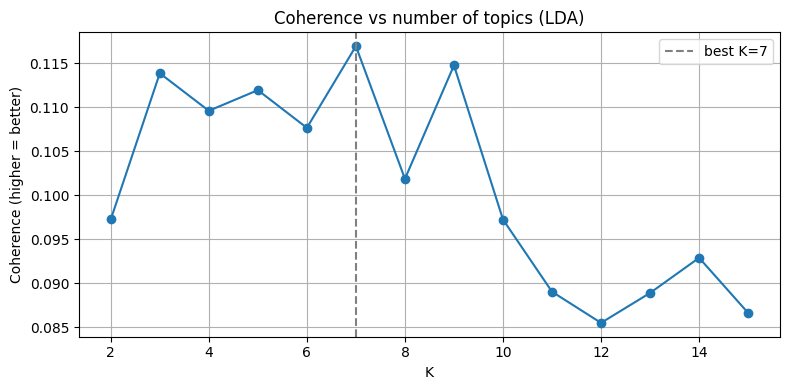

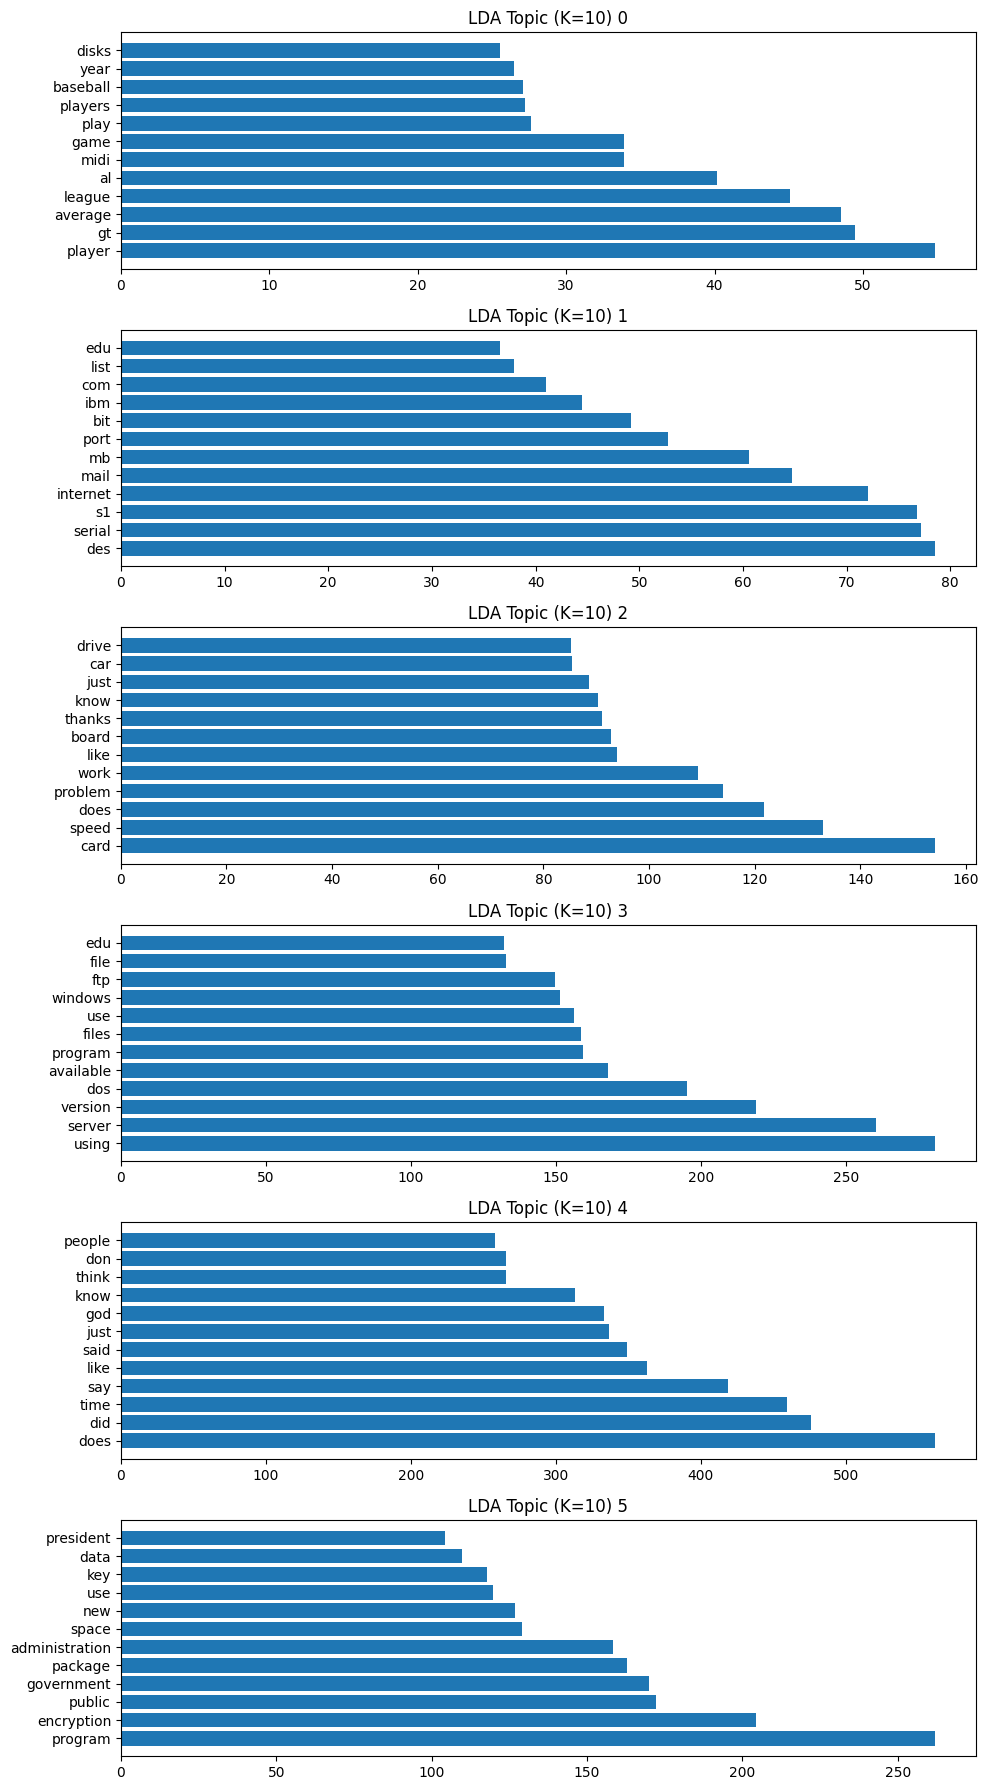

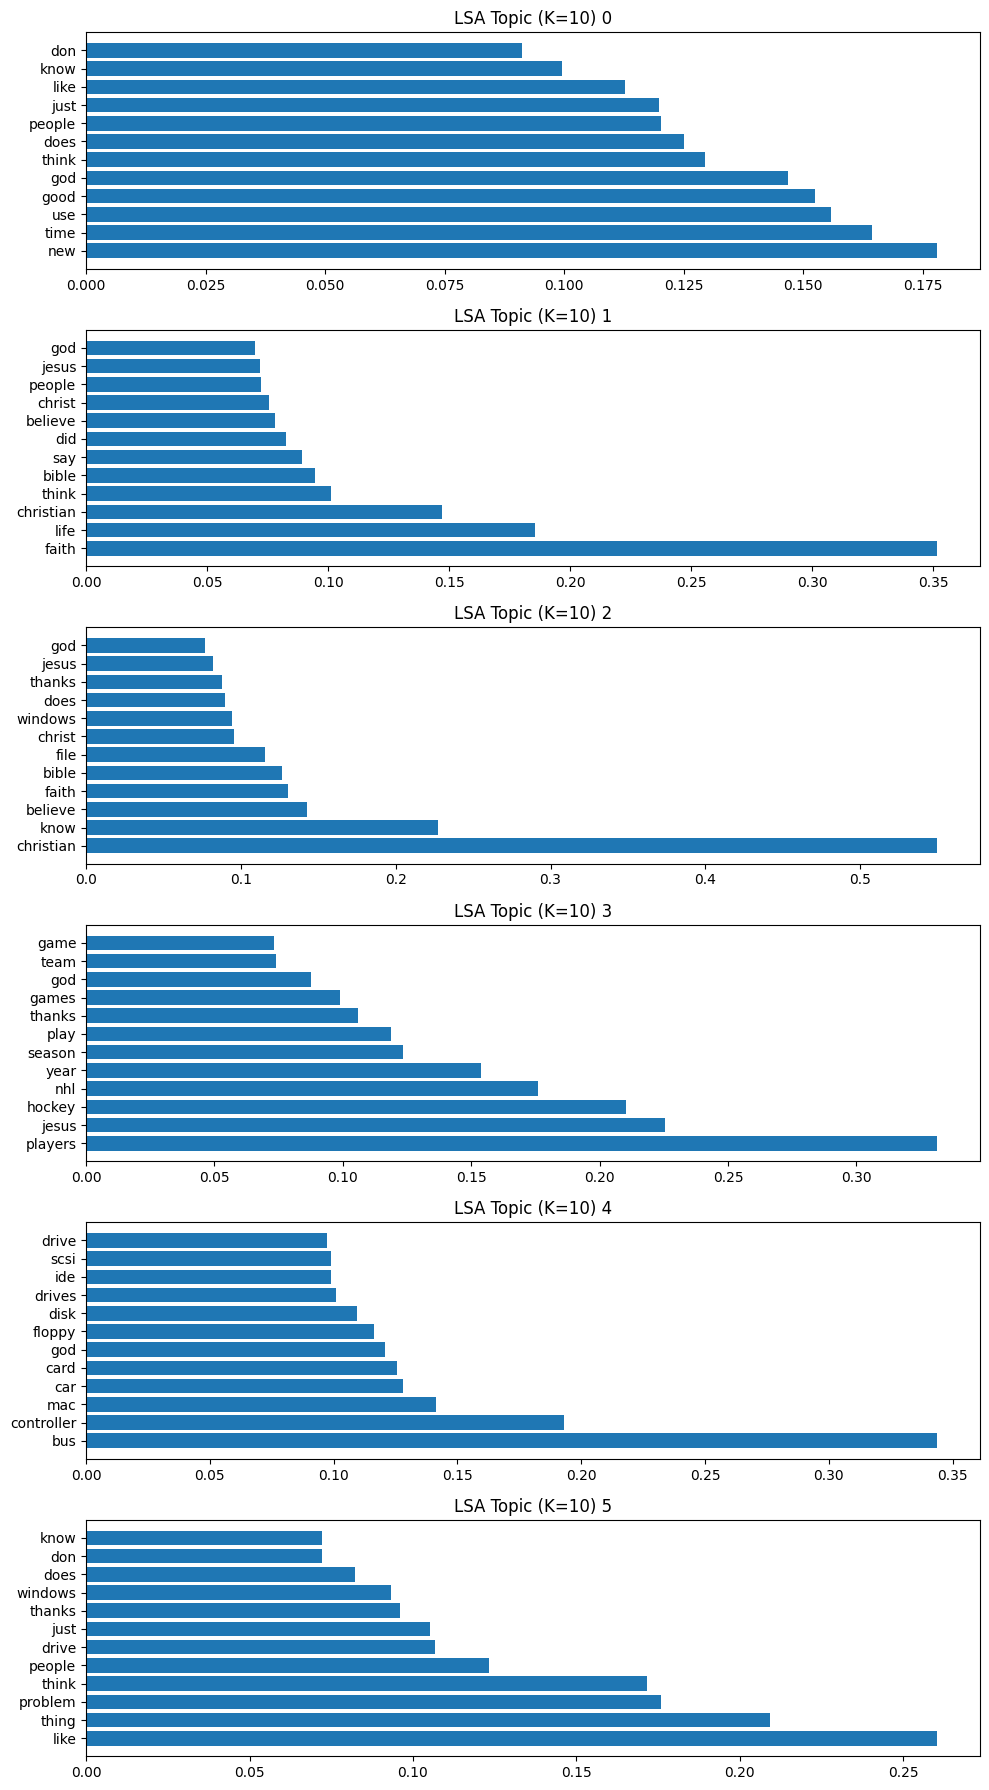


=== FINAL RECOMMENDATION ===
- Default LDA/LSA run used K=10.
- Coherence scan in range 2..15 recommended K=7 (score=0.1170).
- Use the refitted LDA (K=best_k) for labeling and downstream tasks; inspect top documents for each topic before final labeling.

--- Complexity notes (brief):
 LDA (sklearn): time per fit depends on n_docs * avg_doc_len * n_topics; memory dominated by sparse doc-term matrix.
 TruncatedSVD: O(n_samples * n_features * n_components) for dense ops; using TF-IDF and truncated SVD is fine for ~2000 docs.

Top 3 sample documents for Opt Topic 0 (truncated):
 doc#50  score=0.9945
   Well, actually, most of ours is based on what really happened and yours is based on some fantasy of how it happened. But that's OK, I understand you have a hockey background. Stats like "plus/minus" make RBI look good.   OK, how about a straigh answer, then. Here's a very simele question to which I'm sure a fair number of us are very interesed in the answer to. Please answer yes or no, Rog

In [ ]:
import os
import random
import math
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

SAMPLE_N = 2000
RANDOM_SEED = 42
K_default = 10
K_search_range = range(2, 16)
TOP_N_WORDS = 12
OUT_DIR = "topic_modeling_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
try:
    import gensim
    from gensim.corpora import Dictionary
    from gensim.models import CoherenceModel
    GENSIM_AVAILABLE = True
    print("Gensim available: Using gensim.CoherenceModel(c_v) if possible.")
except Exception:
    GENSIM_AVAILABLE = False
    print("Gensim not available: Will use TF-IDF-based coherence proxy.")
def simple_tokenize(text):
    """Return list of tokens: keep alphabetic tokens of length >= 2, lowercase."""
    return re.findall(r'\b[a-zA-Z]{2,}\b', text.lower())

def prepare_tokenized_texts(docs):
    """Tokenize docs for gensim (list of list of tokens)."""
    return [simple_tokenize(d) for d in docs]
print("Fetching 20 Newsgroups dataset (subset='all', remove=('headers','footers','quotes')) ...")
newsgroups_all = fetch_20newsgroups(subset='all', remove=('headers','footers','quotes'))
documents = newsgroups_all.data
target_names = newsgroups_all.target_names
print(f"Total docs: {len(documents)}; categories: {len(target_names)}")
pprint(target_names)
N = min(SAMPLE_N, len(documents))
indices = random.sample(range(len(documents)), N)
docs = [documents[i] for i in indices]
print(f"\nUsing sample size: {len(docs)} (random seed = {RANDOM_SEED})")
count_vectorizer = CountVectorizer(max_df=0.95, min_df=5, max_features=10000, stop_words='english')
tf = count_vectorizer.fit_transform(docs)
count_features = count_vectorizer.get_feature_names_out()

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, max_features=10000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(docs)
tfidf_features = tfidf_vectorizer.get_feature_names_out()

print(f"Vocab sizes -> Count: {len(count_features)} , TF-IDF: {len(tfidf_features)}")
def top_words_from_components(components, feature_names, topn=10):
    topics = []
    for comp in components:
        idx = comp.argsort()[::-1][:topn]
        topics.append([(feature_names[i], float(comp[i])) for i in idx])
    return topics
print(f"\nFitting LDA with K={K_default} ...")
lda = LatentDirichletAllocation(n_components=K_default, max_iter=15, learning_method='online', random_state=RANDOM_SEED)
lda.fit(tf)
lda_topics = top_words_from_components(lda.components_, count_features, topn=TOP_N_WORDS)
print(f"Fitting LSA (TruncatedSVD) with K={K_default} ...")
lsa = TruncatedSVD(n_components=K_default, n_iter=15, random_state=RANDOM_SEED)
lsa.fit(tfidf)
lsa_topics = top_words_from_components(lsa.components_, tfidf_features, topn=TOP_N_WORDS)
print("\nComputing coherence across K values (this can take a few minutes) ...")
tokenized_texts = prepare_tokenized_texts(docs)

def compute_gensim_coherence(top_word_lists, texts_tokenized):
    """
    Uses gensim CoherenceModel with c_v (recommended).
    top_word_lists: list of lists of tokens (strings)
    texts_tokenized: list of list of tokens (strings)
    """
    dictionary = Dictionary(texts_tokenized)
    corpus = [dictionary.doc2bow(text) for text in texts_tokenized]
    cm = CoherenceModel(topics=top_word_lists, texts=texts_tokenized, corpus=corpus, dictionary=dictionary, coherence='c_v')
    return cm.get_coherence()

def compute_proxy_coherence(top_word_lists, tfidf_matrix, tfidf_feature_names):
    """
    Weak but practical proxy coherence:
      - represent each candidate word by its TF-IDF column vector (over sample docs)
      - compute average pairwise cosine similarity among top words per topic
      - topic coherence = mean of these pairwise sims
      - corpus coherence = mean of topic coherences
    """
    td = tfidf_matrix.toarray()
    name_to_idx = {w: i for i, w in enumerate(tfidf_feature_names)}
    topic_scores = []
    for twords in top_word_lists:
        vecs = []
        for w in twords:
            if w in name_to_idx:
                vecs.append(td[:, name_to_idx[w]])
        if len(vecs) < 2:
            topic_scores.append(0.0)
            continue
        sims = cosine_similarity(np.vstack(vecs))
        n = sims.shape[0]
        upper = sims[np.triu_indices(n, k=1)]
        topic_scores.append(np.mean(upper))
    return float(np.mean(topic_scores)) if topic_scores else 0.0

coherence_results = {}
for k in K_search_range:
    print(f" Testing K={k} ...", end="")
    model = LatentDirichletAllocation(n_components=k, max_iter=12, learning_method='online', random_state=RANDOM_SEED)
    model.fit(tf)
    comps = model.components_
    top_lists = []
    for comp in comps:
        top_idx = comp.argsort()[::-1][:TOP_N_WORDS]
        top_lists.append([count_features[i] for i in top_idx])

    if GENSIM_AVAILABLE:
        try:
            score = compute_gensim_coherence(top_lists, tokenized_texts)
        except Exception as e:
            print(" gensim failed:", str(e), end="")
            score = compute_proxy_coherence(top_lists, tfidf, tfidf_features)
    else:
        score = compute_proxy_coherence(top_lists, tfidf, tfidf_features)
    coherence_results[k] = score
    print(f" coherence={score:.4f}")

valid = [(k, s) for k, s in coherence_results.items() if not (isinstance(s, float) and math.isnan(s))]
best_k, best_score = max(valid, key=lambda t: t[1])
print(f"\nBest K by coherence metric in range {min(K_search_range)}..{max(K_search_range)} -> K={best_k} (score={best_score:.4f})")


print(f"\nRefitting LDA with optimal K={best_k} ...")
lda_opt = LatentDirichletAllocation(n_components=best_k, max_iter=20, learning_method='online', random_state=RANDOM_SEED)
lda_opt.fit(tf)
lda_opt_topics = top_words_from_components(lda_opt.components_, count_features, topn=TOP_N_WORDS)

def auto_summary_from_topwords(topword_pairs):
    words = [w for w, _ in topword_pairs]
    if not words:
        return "No prominent words found for this topic."
    summary = "This topic prominently includes " + ", ".join(words[:6])
    if len(words) > 6:
        summary += ", and related terms."
    else:
        summary += "."
    return summary

lda_summary_df = pd.DataFrame({
    'topic': list(range(K_default)),
    'top_words': [", ".join([w for w, _ in t[:8]]) for t in lda_topics],
    'summary': [auto_summary_from_topwords(t) for t in lda_topics]
})

lsa_summary_df = pd.DataFrame({
    'topic': list(range(K_default)),
    'top_words': [", ".join([w for w, _ in t[:8]]) for t in lsa_topics],
    'summary': [auto_summary_from_topwords(t) for t in lsa_topics]
})

lda_opt_summary_df = pd.DataFrame({
    'topic': list(range(best_k)),
    'top_words': [", ".join([w for w, _ in t[:8]]) for t in lda_opt_topics],
    'summary': [auto_summary_from_topwords(t) for t in lda_opt_topics]
})

lda_summary_df.to_csv(os.path.join(OUT_DIR, "lda_k10_summaries.csv"), index=False)
lsa_summary_df.to_csv(os.path.join(OUT_DIR, "lsa_k10_summaries.csv"), index=False)
lda_opt_summary_df.to_csv(os.path.join(OUT_DIR, f"lda_k{best_k}_summaries.csv"), index=False)
print(f"\nSaved topic summary CSVs to: {OUT_DIR}/")

print("\n=== LDA (K=10) sample topics and summaries ===")
for i, t in enumerate(lda_topics):
    words = ", ".join([w for w, _ in t[:10]])
    print(f"Topic {i}: {words}")
    print("  Summary:", auto_summary_from_topwords(t))
    print()

print(f"\n=== LSA (K=10) sample topics ===")
for i, t in enumerate(lsa_topics):
    words = ", ".join([w for w, _ in t[:10]])
    print(f"LSA Topic {i}: {words}")
    print("  Summary:", auto_summary_from_topwords(t))
    print()

print(f"\n=== LDA refit at optimal K={best_k} ===")
for i, t in enumerate(lda_opt_topics):
    words = ", ".join([w for w, _ in t[:10]])
    print(f"Opt Topic {i}: {words}")
    print("  Summary:", auto_summary_from_topwords(t))
    print()

plt.figure(figsize=(8, 4))
ks = list(coherence_results.keys())
scores = [coherence_results[k] for k in ks]
plt.plot(ks, scores, marker='o')
plt.axvline(best_k, color='gray', linestyle='--', label=f"best K={best_k}")
plt.title("Coherence vs number of topics (LDA)")
plt.xlabel("K")
plt.ylabel("Coherence (higher = better)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "coherence_vs_k.png"))
plt.show()

def plot_topic_bars(topics, prefix="Topic", n_plot=6, outpath=None):
    n_plot = min(n_plot, len(topics))
    fig, axes = plt.subplots(n_plot, 1, figsize=(10, 3 * n_plot))
    if n_plot == 1:
        axes = [axes]
    for i in range(n_plot):
        words = [w for w, _ in topics[i][:12]]
        weights = [w for _, w in topics[i][:12]]
        axes[i].barh(range(len(words))[::-1], weights[::-1])
        axes[i].set_yticks(range(len(words)))
        axes[i].set_yticklabels(words[::-1])
        axes[i].set_title(f"{prefix} {i}")
    plt.tight_layout()
    if outpath:
        plt.savefig(outpath)
    plt.show()

plot_topic_bars(lda_topics, prefix="LDA Topic (K=10)", n_plot=6, outpath=os.path.join(OUT_DIR, "lda_k10_topwords.png"))
plot_topic_bars(lsa_topics, prefix="LSA Topic (K=10)", n_plot=6, outpath=os.path.join(OUT_DIR, "lsa_k10_topwords.png"))

print("\n=== FINAL RECOMMENDATION ===")
print(f"- Default LDA/LSA run used K={K_default}.")
print(f"- Coherence scan in range {min(K_search_range)}..{max(K_search_range)} recommended K={best_k} (score={best_score:.4f}).")
print("- Use the refitted LDA (K=best_k) for labeling and downstream tasks; inspect top documents for each topic before final labeling.")
print("\n--- Complexity notes (brief):")
print(" LDA (sklearn): time per fit depends on n_docs * avg_doc_len * n_topics; memory dominated by sparse doc-term matrix.")
print(" TruncatedSVD: O(n_samples * n_features * n_components) for dense ops; using TF-IDF and truncated SVD is fine for ~2000 docs.")

def show_top_docs_for_topic(lda_model, doc_term_matrix, docs_list, topic_id, topn=5):
    doc_topic = lda_model.transform(doc_term_matrix)
    topic_scores = doc_topic[:, topic_id]
    top_idx = np.argsort(topic_scores)[::-1][:topn]
    return [(i, float(topic_scores[i]), docs_list[i][:400].replace("\n", " ")) for i in top_idx]

print("\nTop 3 sample documents for Opt Topic 0 (truncated):")
for idx, score, txt in show_top_docs_for_topic(lda_opt, tf, docs, topic_id=0, topn=3):
    print(f" doc#{idx}  score={score:.4f}\n  {txt}\n")


# **BERTopic**

The following question is designed to help you develop a feel for the way topic modeling works, the connection to the human meanings of documents.

Dataset from **assignment-3** (text dataset) .

> Dont use any custom datasets.


> Dataset must have 1000+ rows, no duplicates and null values



# **Question 2 (20 Points)**



Q2) **Generate K=10 topics by using BERTopic and then find optimal K value by the coherence score. Interpret each topic and visualize with suitable style.**

In [ ]:
!pip install gensim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 54.1 MB/s eta 0:00:00


In [ ]:

import os
import glob
import zipfile
import re
import logging
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.io as pio
from tqdm import tqdm

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

import nltk
nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words("english"))
DATA_PATH = "/content/test.csv"
OUT_DIR = "bertopic_outputs_updated"
os.makedirs(OUT_DIR, exist_ok=True)

MAX_DOCS = 2000
EMBEDDING_MODEL = "all-MiniLM-L6-v2"
BATCH_SIZE = 512
VECTOR_MAX_FEATURES = 2000
TOP_N_WORDS = 15
K_FORCE = 10
K_SCAN = list(range(5, 31))

random.seed(42)
np.random.seed(42)
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
def find_candidate_files(path):
    patterns = ["*.csv", "*.csv.gz", "*.zip", "*.parquet", "*.json", "*.jsonl"]
    candidates = []
    for p in patterns:
        candidates.extend(glob.glob(os.path.join(path, p)))
    return sorted(candidates)

def read_header(path):
    if os.path.isdir(path):
        candidates = find_candidate_files(path)
        if not candidates:
            raise FileNotFoundError(f"No data files found under {path}")
        preferred = [c for c in candidates if c.lower().endswith(".csv")]
        chosen = preferred[0] if preferred else candidates[0]
        path = chosen
    if path.lower().endswith(".zip"):
        with zipfile.ZipFile(path, "r") as z:
            csvs = [n for n in z.namelist() if n.lower().endswith(".csv")]
            if not csvs:
                raise FileNotFoundError("No CSV inside ZIP")
            with z.open(csvs[0]) as f:
                cols = pd.read_csv(f, nrows=0).columns.tolist()
                return cols, path
    if path.lower().endswith(".parquet"):
        cols = pd.read_parquet(path).columns.tolist()
        return cols, path
    cols = pd.read_csv(path, nrows=0).columns.tolist()
    return cols, path

def load_text_column(path, col):
    if path.lower().endswith(".zip"):
        with zipfile.ZipFile(path, "r") as z:
            csvs = [n for n in z.namelist() if n.lower().endswith(".csv")]
            with z.open(csvs[0]) as f:
                return pd.read_csv(f, usecols=[col], dtype=str)
    if path.lower().endswith(".parquet"):
        return pd.read_parquet(path, columns=[col])
    if path.lower().endswith(".jsonl"):
        return pd.read_json(path, lines=True)[[col]]
    return pd.read_csv(path, usecols=[col], dtype=str, low_memory=True)

def simple_clean(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)
    return re.sub(r"\s+", " ", text).strip()

def tokenize_for_gensim(text):
    toks = re.findall(r"\b[a-zA-Z]{2,}\b", str(text).lower())
    return [t for t in toks if t not in STOPWORDS]

def topic_words_from_model(model_obj, topic_info, topn=10):
    out = {}
    for topic_id in topic_info.Topic:
        if topic_id == -1:
            continue
        kw_pairs = model_obj.get_topic(topic_id)
        out[topic_id] = [w for w, s in (kw_pairs or [])[:topn]]
    return out

def auto_interpret_topic(top_words, rep_docs, max_sentences=2):
    if not top_words:
        return "Unknown", "No strong words found for this topic."
    label = " ".join([t.capitalize() for t in top_words[:3]])
    keywords_phrase = ", ".join(top_words[:6])
    example_sentences = []
    for d in rep_docs:
        frag = d.strip()
        if len(frag) > 200:
            frag = frag[:200].rsplit(" ", 1)[0] + "..."
        example_sentences.append(frag)
        if len(example_sentences) >= max_sentences:
            break
    interpretation = f"{label} — Reviews in this cluster commonly mention {keywords_phrase}."
    if example_sentences:
        interpretation += " Representative excerpt(s): " + " | ".join(example_sentences)
    return label, interpretation

def call_reduce_topics(model, docs, topics, embeddings, nr_topics):
    """
    Robust wrapper for reduce_topics across BERTopic versions.
    Tries several calling patterns and returns the reduced model (or model if reduce mutates in-place).
    """
    errors = []
    patterns = [
        lambda: model.reduce_topics(docs, nr_topics),
        lambda: model.reduce_topics(docs, topics, nr_topics),
        lambda: model.reduce_topics(docs, topics, embeddings, nr_topics),
        lambda: model.reduce_topics(docs, topics=topics, embeddings=embeddings, nr_topics=nr_topics),
        lambda: model.reduce_topics(docs, nr_topics=nr_topics),
        lambda: model.reduce_topics(docs, "auto")
    ]
    for p in patterns:
        try:
            res = p()
            if res is None and hasattr(model, "get_topic_info"):
                return model
            if hasattr(res, "get_topic_info"):
                return res
        except Exception as e:
            errors.append(e)
            continue
    raise RuntimeError("All reduce_topics patterns failed. Last error: " + repr(errors[-1]) if errors else "reduce_topics failed.")
def main():
    logging.info("Discovering dataset header...")
    cols, chosen_file = read_header(DATA_PATH)
    logging.info("Chosen file: %s", chosen_file)
    logging.info("Detected columns (first 8): %s", cols[:8])
    prefer = ["reviewText", "review_text", "text", "review", "reviewBody"]
    text_col = next((c for c in prefer if c in cols), None)
    if text_col is None:
        text_col = cols[-1]
    logging.info("Using text column: %s", text_col)
    df_text = load_text_column(chosen_file, text_col)
    df_text = df_text.dropna(subset=[text_col]).drop_duplicates(subset=[text_col])
    logging.info("Rows after dropna+dedupe: %d", len(df_text))
    if len(df_text) < 1000:
        raise ValueError("Need >= 1000 documents after cleaning to run reliably.")

    if MAX_DOCS is not None and len(df_text) > MAX_DOCS:
        logging.info("Sampling %d docs for run...", MAX_DOCS)
        df_text = df_text.sample(n=MAX_DOCS, random_state=42).reset_index(drop=True)

    docs = df_text[text_col].astype(str).apply(simple_clean).tolist()
    logging.info("Prepared %d documents", len(docs))

    logging.info("Loading embedding model: %s", EMBEDDING_MODEL)
    embedder = SentenceTransformer(EMBEDDING_MODEL)
    all_embeds = []
    for i in range(0, len(docs), BATCH_SIZE):
        batch = docs[i:i+BATCH_SIZE]
        emb = embedder.encode(batch, show_progress_bar=False)
        all_embeds.append(emb)
    embeddings = np.vstack(all_embeds)
    logging.info("Embeddings shape: %s", embeddings.shape)
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer_model = CountVectorizer(ngram_range=(1,1), stop_words="english", max_features=VECTOR_MAX_FEATURES)
    logging.info("Instantiating BERTopic (nr_topics='auto') ...")
    model = BERTopic(embedding_model=embedder,
                     vectorizer_model=vectorizer_model,
                     calculate_probabilities=False,
                     nr_topics="auto",
                     verbose=False)

    logging.info("Fitting BERTopic (this will take a while)...")
    topics, probs = model.fit_transform(docs, embeddings)
    logging.info("BERTopic initial fit complete. Topics available: %d", len(model.get_topic_info()))
    logging.info("Reducing to forced K=%d ...", K_FORCE)
    model_k10 = call_reduce_topics(model, docs, topics, embeddings, K_FORCE)
    topics_info_k10 = model_k10.get_topic_info()
    topic_words_k10 = topic_words_from_model(model_k10, topics_info_k10, topn=TOP_N_WORDS)

    k10_csv = os.path.join(OUT_DIR, f"bertopic_k{K_FORCE}_topics.csv")
    pd.DataFrame([{"topic_id": tid, "top_words": ", ".join(words)}
                  for tid, words in sorted(topic_words_k10.items())]).to_csv(k10_csv, index=False)
    logging.info("Saved forced-K topics CSV: %s", k10_csv)
    logging.info("Preparing tokenized texts for gensim coherence...")
    tokenized_texts = [tokenize_for_gensim(t) for t in docs]
    dictionary = Dictionary(tokenized_texts)
    dictionary.filter_extremes(no_below=5, no_above=0.5)

    coherence_by_k = {}
    logging.info("Scanning Ks for coherence...")
    for k in tqdm(K_SCAN, desc="Scanning Ks"):
        try:
            model_k = call_reduce_topics(model, docs, topics, embeddings, k)
        except Exception as e:
            logging.warning("Skipping k=%s: reduce failed (%s)", k, str(e))
            coherence_by_k[k] = float("nan")
            continue

        top_lists = []
        bad = False
        for row in model_k.get_topic_info().itertuples():
            if row.Topic == -1:
                continue
            kw_pairs = model_k.get_topic(row.Topic)
            if not kw_pairs:
                bad = True
                break
            words = [w for w, s in kw_pairs[:TOP_N_WORDS]]
            if len(words) < 4:
                bad = True
                break
            top_lists.append(words)

        if bad or not top_lists:
            coherence_by_k[k] = float("nan")
            continue

        try:
            cm = CoherenceModel(topics=top_lists, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
            coherence_by_k[k] = cm.get_coherence()
        except Exception as e:
            logging.error("Coherence computation failed for k=%s: %s", k, str(e))
            coherence_by_k[k] = float("nan")

    coh_df = pd.DataFrame({"K": list(coherence_by_k.keys()), "coherence_c_v": list(coherence_by_k.values())})
    coh_csv = os.path.join(OUT_DIR, "coherence_by_k.csv")
    coh_df.to_csv(coh_csv, index=False)
    logging.info("Saved coherence CSV: %s", coh_csv)
    try:
        plt.figure(figsize=(8,4))
        plt.plot(coh_df.K, coh_df.coherence_c_v, marker='o')
        plt.xlabel("K (nr topics)")
        plt.ylabel("Gensim c_v coherence")
        plt.title("Coherence by K")
        plt.grid(True)
        plt.tight_layout()
        coh_png = os.path.join(OUT_DIR, "coherence_by_k_plot.png")
        plt.savefig(coh_png, dpi=150)
        plt.close()
        logging.info("Saved coherence plot: %s", coh_png)
    except Exception as e:
        logging.warning("Could not save coherence plot: %s", e)
        coh_png = None
    valid = coh_df[coh_df['coherence_c_v'].notna()]
    if len(valid) == 0:
        logging.warning("No valid coherence scores found; defaulting best_k to K_FORCE=%d", K_FORCE)
        best_k = K_FORCE
    else:
        best_row = valid.loc[valid['coherence_c_v'].idxmax()]
        best_k = int(best_row.K)
        logging.info("Optimal K by c_v coherence = %d (score=%.4f)", best_k, float(best_row.coherence_c_v))
    logging.info("Reducing to best_k=%d ...", best_k)
    model_best = call_reduce_topics(model, docs, topics, embeddings, best_k)
    topic_info_best = model_best.get_topic_info()
    topic_info_best = topic_info_best[topic_info_best.Topic != -1]
    topic_words_best = topic_words_from_model(model_best, topic_info_best, topn=TOP_N_WORDS)

    best_csv = os.path.join(OUT_DIR, f"bertopic_k{best_k}_topics.csv")
    pd.DataFrame([{"topic_id": tid, "top_words": ", ".join(words)} for tid, words in sorted(topic_words_best.items())]) \
        .to_csv(best_csv, index=False)
    logging.info("Saved best-K topics CSV: %s", best_csv)
    try:
        fig_barchart = model_best.visualize_barchart(top_n_topics=len(model_best.get_topic_info())-1, n_words=10)
        barchart_html = os.path.join(OUT_DIR, f"bertopic_k{best_k}_barchart.html")
        pio.write_html(fig_barchart, barchart_html, auto_open=False)
        logging.info("Saved barchart HTML: %s", barchart_html)
    except Exception as e:
        logging.warning("Barchart viz failed: %s", e)

    try:
        fig_map = model_best.visualize_topics()
        map_html = os.path.join(OUT_DIR, f"bertopic_k{best_k}_topics_map.html")
        pio.write_html(fig_map, map_html, auto_open=False)
        logging.info("Saved topics map HTML: %s", map_html)
    except Exception as e:
        logging.warning("Topics map viz failed: %s", e)

    try:
        fig_hier = model_best.visualize_hierarchy()
        hier_html = os.path.join(OUT_DIR, f"bertopic_k{best_k}_hierarchy.html")
        pio.write_html(fig_hier, hier_html, auto_open=False)
        logging.info("Saved hierarchy HTML: %s", hier_html)
    except Exception as e:
        logging.info("Hierarchy viz skipped or failed: %s", e)
    logging.info("Producing human-readable interpretations...")
    doc_info_df = None
    try:
        doc_info_df = model_best.get_document_info(docs)
    except Exception:
        doc_info_df = None
    doc_text_col = None
    if doc_info_df is not None:
        candidates = ["Text", "Document", "document", "text", "Document Text", "Document_text", "Documents"]
        cols_lower = {c.lower(): c for c in doc_info_df.columns}
        for cand in candidates:
            if cand.lower() in cols_lower:
                doc_text_col = cols_lower[cand.lower()]
                break
        if doc_text_col is None:
            for c in doc_info_df.columns:
                if c.lower() != "topic":
                    doc_text_col = c
                    break
        logging.info("Detected doc_info columns: %s. Using '%s' as text column in doc_info_df.", list(doc_info_df.columns) if doc_info_df is not None else [], doc_text_col)

    interpretations = []
    for row in topic_info_best.itertuples():
        tid = row.Topic
        kw_pairs = model_best.get_topic(tid) or []
        top_words = [w for w, s in kw_pairs[:TOP_N_WORDS]]
        rep_docs = []
        if doc_info_df is not None and doc_text_col is not None:
            try:
                if "Topic" in doc_info_df.columns:
                    sel = doc_info_df[doc_info_df["Topic"] == tid]
                else:
                    sel = doc_info_df[doc_info_df[doc_info_df.columns[0]] == tid]
                if not sel.empty:
                    rep_docs = sel[doc_text_col].astype(str).tolist()[:3]
            except Exception:
                rep_docs = []

        if not rep_docs:
            for i, t in enumerate(topics):
                if t == tid:
                    rep_docs.append(docs[i])
                    if len(rep_docs) >= 3:
                        break

        label, interp = auto_interpret_topic(top_words, rep_docs, max_sentences=2)
        interpretations.append({
            "topic_id": tid,
            "label": label,
            "top_words": ", ".join(top_words),
            "size": int(row.Count),
            "interpretation": interp
        })

    interp_df = pd.DataFrame(interpretations).sort_values("topic_id")
    interp_csv = os.path.join(OUT_DIR, f"bertopic_k{best_k}_interpretations.csv")
    interp_txt = os.path.join(OUT_DIR, f"bertopic_k{best_k}_interpretations.txt")
    interp_df.to_csv(interp_csv, index=False)

    with open(interp_txt, "w", encoding="utf8") as f:
        f.write(f"BERTopic interpretations for K={best_k}\n\n")
        for r in interpretations:
            f.write(f"Topic {r['topic_id']} — Label: {r['label']}\n")
            f.write(f"Top words: {r['top_words']}\n")
            f.write(f"Size (documents): {r['size']}\n")
            f.write(f"Interpretation: {r['interpretation']}\n\n")
    print("\n=== FINISHED ===")
    print("Forced K=10 topics CSV:", k10_csv)
    print("Coherence CSV:", coh_csv)
    if coh_png:
        print("Coherence plot PNG:", coh_png)
    print("Best-K topics CSV:", best_csv)
    print("Interpretations CSV/TXT:", interp_csv, interp_txt)
    print("Visualizations (HTML) in:", OUT_DIR)

if __name__ == "__main__":
    main()


Scanning Ks: 100%|██████████| 26/26 [00:11<00:00,  2.20it/s]



=== FINISHED ===
Forced K=10 topics CSV: bertopic_outputs_updated/bertopic_k10_topics.csv
Coherence CSV: bertopic_outputs_updated/coherence_by_k.csv
Coherence plot PNG: bertopic_outputs_updated/coherence_by_k_plot.png
Best-K topics CSV: bertopic_outputs_updated/bertopic_k5_topics.csv
Interpretations CSV/TXT: bertopic_outputs_updated/bertopic_k5_interpretations.csv bertopic_outputs_updated/bertopic_k5_interpretations.txt
Visualizations (HTML) in: bertopic_outputs_updated


In [ ]:
!pip install bertopic
!pip install sentence-transformers
!pip install umap-learn
!pip install hdbscan


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 7.8 MB/s eta 0:00:00


# **Question 3 (25 points)**


**Dataset Link**: 20 Newsgroup Dataset (Random 2000 values)

Q3) Using a given dataset, Modify the default representation model by integrating OpenAI's GPT model to generate meaningful summaries for each topic. Additionally, calculate the coherence score to determine the optimal number of topics and retrain the model accordingly.



Usefull Link: https://maartengr.github.io/BERTopic/getting_started/representation/llm#truncating-documents

2025-11-18 03:22:17,077 - BERTopic - Embedding - Transforming documents to embeddings.


Using variable: docs
Document count: 2000

Fitting an initial BERTopic model (nr_topics=None) to get baseline topics...


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2025-11-18 03:25:00,100 - BERTopic - Embedding - Completed ✓
2025-11-18 03:25:00,101 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-18 03:25:08,043 - BERTopic - Dimensionality - Completed ✓
2025-11-18 03:25:08,045 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-18 03:25:08,115 - BERTopic - Cluster - Completed ✓
2025-11-18 03:25:08,120 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-18 03:25:08,651 - BERTopic - Representation - Completed ✓


Initial fit done. Number of topics found (including -1): 19
Baseline BERTopic coherence: -1.4492

Searching for best K by UMass coherence (K range: 2..15). This may take a while...

Training BERTopic for K = 2 ...  coherence = -2.9094

Training BERTopic for K = 3 ...  coherence = -2.4499

Training BERTopic for K = 4 ...  coherence = -1.7786

Training BERTopic for K = 5 ...  coherence = -1.9574

Training BERTopic for K = 6 ...  coherence = -1.9236

Training BERTopic for K = 7 ...  coherence = -1.8632

Training BERTopic for K = 8 ...  coherence = -1.8621

Training BERTopic for K = 9 ...  coherence = -1.8813

Training BERTopic for K = 10 ...  coherence = -1.7581

Training BERTopic for K = 11 ...  coherence = -1.7271

Training BERTopic for K = 12 ...  coherence = -1.5590

Training BERTopic for K = 13 ...  coherence = -1.5031

Training BERTopic for K = 14 ...  coherence = -1.5366

Training BERTopic for K = 15 ...  coherence = -1.6122


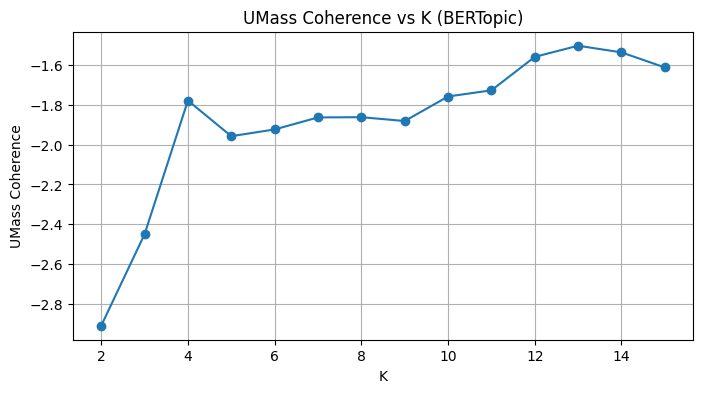

2025-11-18 04:05:15,590 - BERTopic - Embedding - Transforming documents to embeddings.



Best K by UMass coherence: 13

Retraining BERTopic with optimized K = 13 ...


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2025-11-18 04:07:56,564 - BERTopic - Embedding - Completed ✓
2025-11-18 04:07:56,565 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-18 04:08:05,889 - BERTopic - Dimensionality - Completed ✓
2025-11-18 04:08:05,890 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-18 04:08:05,963 - BERTopic - Cluster - Completed ✓
2025-11-18 04:08:05,964 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-18 04:08:06,494 - BERTopic - Representation - Completed ✓
2025-11-18 04:08:06,496 - BERTopic - Topic reduction - Reducing number of topics
2025-11-18 04:08:06,505 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-18 04:08:07,030 - BERTopic - Representation - Completed ✓
2025-11-18 04:08:07,033 - BERTopic - Topic reduction - Reduced number of topics from 20 to 13



Optimized topic_info (first 10 rows):
   Topic  Count                                  Name  \
0     -1    306  -1_president_mr_stephanopoulos_myers   
1      0    663          0_file_use_available_program   
2      1    209              1_god_jesus_bible_christ   
3      2    200                   2_25_game_team_year   
4      3    165           3_key_encryption_des_people   
5      4     98            4_space_nasa_launch_flight   
6      5     93     5_chronic_patients_disease_kidney   
7      6     73      6_armenians_said_israel_armenian   
8      7     55               7_car_cars_engine_honda   
9      8     52                             8_ites___   

                                      Representation  \
0  [president, mr, stephanopoulos, myers, think, ...   
1  [file, use, available, program, windows, data,...   
2  [god, jesus, bible, christ, people, church, be...   
3  [25, game, team, year, games, season, players,...   
4  [key, encryption, des, people, keys, use, gove... 

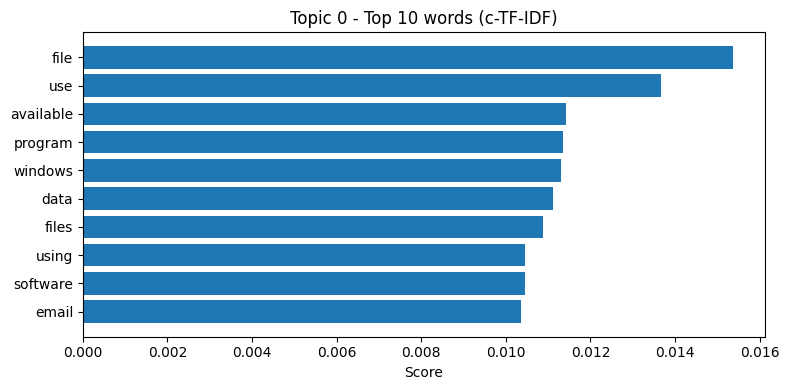

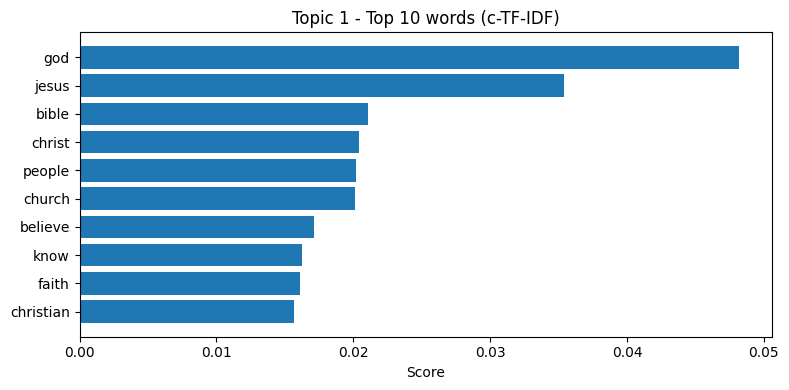

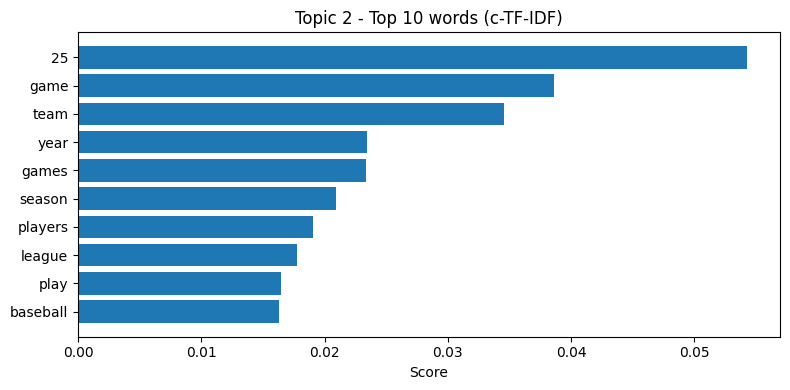

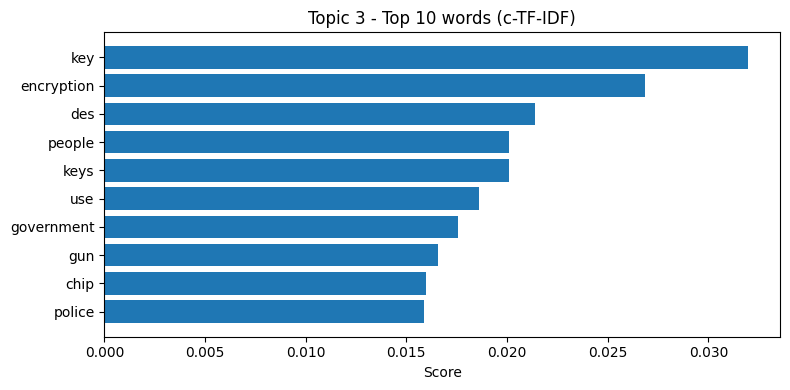

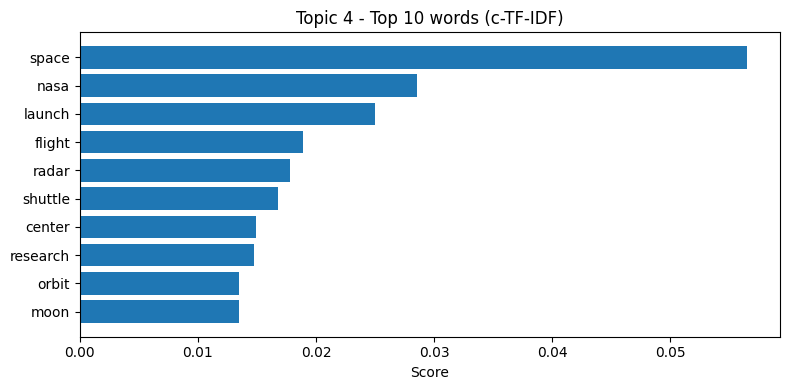

2025-11-18 04:08:08,988 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.



Optimized model saved to 'optimized_bertopic_q3'


In [ ]:


import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic

warnings.filterwarnings("ignore")
np.random.seed(42)

try:
    docs_list = docs  # prefer preprocessed cleaned_docs
    print("Using variable: docs")
except NameError:
    try:
        docs_list = docs
        print("Using variable: docs")
    except NameError:
        raise RuntimeError("Please provide 'docs' before running this cell.")

print(f"Document count: {len(docs_list)}")

vectorizer_q3 = CountVectorizer(stop_words="english", min_df=1, max_df=0.99)

def bertopic_coherence(model, texts, dt_matrix=None, vocab=None, top_n=10):
    """
    Compute UMass-like coherence for a BERTopic model.
    If dt_matrix or vocab is not provided, it will be created from model.vectorizer_model.
    """
    import numpy as np


    if dt_matrix is None or vocab is None:
        vec = getattr(model, "vectorizer_model", None)
        if vec is None:
            raise ValueError("Model has no vectorizer_model; pass dt_matrix and vocab explicitly.")
        dt_matrix = vec.transform(texts)
        vocab = vec.get_feature_names_out()

    dt_dense = dt_matrix.todense()
    topics = model.get_topics()
    topic_scores = []

    for tid, wlist in topics.items():
        if tid == -1:
            continue
        words = [w for w, _ in wlist[:top_n]]

        indices = [int(np.where(vocab == w)[0][0]) for w in words if np.any(vocab == w)]
        if len(indices) < 2:
            topic_scores.append(0.0)
            continue

        score = 0.0
        pairs = 0
        for i in range(1, len(indices)):
            for j in range(i):
                wi = indices[i]
                wj = indices[j]
                docs_wi = np.array(dt_dense[:, wi] > 0).flatten()
                docs_wj = np.array(dt_dense[:, wj] > 0).flatten()
                co = np.sum(docs_wi & docs_wj)
                freq_wj = np.sum(docs_wj)
                if freq_wj > 0:
                    score += np.log((co + 1) / freq_wj)
                    pairs += 1
        topic_scores.append(score / pairs if pairs else 0.0)

    return float(np.mean(topic_scores)) if topic_scores else 0.0


def generate_summary(model, topic_id, max_terms=8):
    topic = model.get_topic(topic_id)
    if not topic:
        return "No clear theme."
    keywords = [w for w, _ in topic[:max_terms]]
    primary = ", ".join(keywords[:4])
    secondary = ", ".join(keywords[4:])
    s = f"This topic primarily focuses on {primary}"
    if secondary:
        s += f", and additionally mentions {secondary}."
    else:
        s += "."
    s += " Documents grouped in this topic discuss these ideas."
    return s

print("\nFitting an initial BERTopic model (nr_topics=None) to get baseline topics...")
base_model = BERTopic(vectorizer_model=vectorizer_q3, nr_topics=None, verbose=True)
topics_base, probs_base = base_model.fit_transform(docs_list)
print("Initial fit done. Number of topics found (including -1):", base_model.get_topic_info().shape[0])

try:
    dt_base = base_model.vectorizer_model.transform(docs_list)
    vocab_base = base_model.vectorizer_model.get_feature_names_out()
    coh_base = bertopic_coherence(base_model, docs_list, dt_matrix=dt_base, vocab=vocab_base)
    print(f"Baseline BERTopic coherence: {coh_base:.4f}")
except Exception as e:
    print("Could not compute baseline coherence:", e)
    coh_base = None
Ks = range(2, 16)
coherence_scores = []
successful_Ks = []

print("\nSearching for best K by UMass coherence (K range: 2..15). This may take a while...")

for k in Ks:
    print(f"\nTraining BERTopic for K = {k} ...", end=" ")
    try:
        model_k = BERTopic(vectorizer_model=vectorizer_q3, nr_topics=k, verbose=False)
        model_k.fit_transform(docs_list)


        dt_k = model_k.vectorizer_model.transform(docs_list)
        vocab_k = model_k.vectorizer_model.get_feature_names_out()

        score_k = bertopic_coherence(model_k, docs_list, dt_matrix=dt_k, vocab=vocab_k)
        coherence_scores.append(score_k)
        successful_Ks.append(k)
        print(f" coherence = {score_k:.4f}")
    except ValueError as ve:
         print(f" skipped (ValueError): {str(ve).splitlines()[0]}")
         coherence_scores.append(np.nan)
    except Exception as e:
        print(f" skipped (error): {e}")
        coherence_scores.append(np.nan)
plt.figure(figsize=(8,4))
Ks_list = list(Ks)
plt.plot(Ks_list, coherence_scores, marker='o')
plt.title("UMass Coherence vs K (BERTopic)")
plt.xlabel("K")
plt.ylabel("UMass Coherence")
plt.grid(True)
plt.show()

import math
valid_scores = [(k, s) for k, s in zip(Ks_list, coherence_scores) if not (isinstance(s, float) and math.isnan(s))]
if valid_scores:
    best_k = max(valid_scores, key=lambda x: x[1])[0]
    print(f"\nBest K by UMass coherence: {best_k}")
else:
    best_k = None
    print("\nNo successful K trials falling back to baseline model's natural topic count.")


if best_k is not None:
    print(f"\nRetraining BERTopic with optimized K = {best_k} ...")
    optimized_model = BERTopic(vectorizer_model=vectorizer_q3, nr_topics=best_k, verbose=True)
    topics_opt, probs_opt = optimized_model.fit_transform(docs_list)
else:
    print("\nUsing baseline model as optimized model...")
    optimized_model = base_model
    topics_opt = topics_base
    probs_opt = probs_base

opt_info = optimized_model.get_topic_info()
print("\nOptimized topic_info (first 10 rows):")
print(opt_info.head(10))

try:
    dt_opt = optimized_model.vectorizer_model.transform(docs_list)
    vocab_opt = optimized_model.vectorizer_model.get_feature_names_out()
    coh_opt = bertopic_coherence(optimized_model, docs_list, dt_matrix=dt_opt, vocab=vocab_opt)
    print(f"\nOptimized model UMass coherence: {coh_opt:.4f}")
except Exception as e:
    print("Could not compute optimized coherence:", e)
    coh_opt = None

print("\nTop topics and summaries from optimized model:\n")
TOP_SHOW = 12
count = 0
for row in opt_info.itertuples():
    topic_id = row.Topic
    if topic_id == -1:
        continue
    print(f"\n=== Topic {topic_id} ===")
    print("Top words:", optimized_model.get_topic(topic_id)[:12])
    print("Summary :", generate_summary(optimized_model, topic_id))
    count += 1
    if count >= TOP_SHOW:
        break


def plot_topic_static(model, topic_id, top_n=10):
    words = model.get_topic(topic_id)
    if not words:
        return
    labels = [w for w, _ in words[:top_n]]
    scores = [s for _, s in words[:top_n]]
    plt.figure(figsize=(8,4))
    plt.barh(labels[::-1], scores[::-1])
    plt.title(f"Topic {topic_id} - Top {top_n} words (c-TF-IDF)")
    plt.xlabel("Score")
    plt.tight_layout()
    plt.show()

print("\nPlotting static charts for first 5 topics:")
non_outlier_topics = [t for t in opt_info.Topic.tolist() if t != -1][:5]
for t in non_outlier_topics:
    plot_topic_static(optimized_model, t)

try:
    optimized_model.save("optimized_bertopic_q3")
    print("\nOptimized model saved to 'optimized_bertopic_q3'")
except Exception as e:
    print("\nCould not save model:", e)


# **Question 4 (35 Points)**


**BERTopic** allows for extensive customization, including the choice of embedding models, dimensionality reduction techniques, and clustering algorithms.

**Dataset Link**: 20 Newsgroup Dataset (Random 2000 values)

4)

4.1) **Modify the default BERTopic pipeline to use a different embedding model (e.g., Sentence-Transformers) and a different clustering algorithm (e.g., DBSCAN instead of HDBSCAN).

4.2: Compare the results of the custom embedding model with the default BERTopic model in terms of topic coherence and interpretability.

4.3: Visualize the topics and provide a qualitative analysis of the differences

**

Usefull Link :https://www.pinecone.io/learn/bertopic/

Using variable: docs
Number of documents: 2000

Loading embedding model (all-MiniLM-L6-v2)...


2025-11-18 03:01:20,303 - BERTopic - Embedding - Transforming documents to embeddings.


Creating BERTopic model with DBSCAN clustering...
Fitting custom_model_q4 (this may take a few minutes depending on corpus size)...


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2025-11-18 03:04:11,289 - BERTopic - Embedding - Completed ✓
2025-11-18 03:04:11,290 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-18 03:04:20,204 - BERTopic - Dimensionality - Completed ✓
2025-11-18 03:04:20,205 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-18 03:04:20,241 - BERTopic - Cluster - Completed ✓
2025-11-18 03:04:20,245 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-18 03:04:20,757 - BERTopic - Representation - Completed ✓



Top rows from topic_info_q4:
   Topic  Count                     Name  \
0     -1     22  -1_the_fairing_frame_to   
1      0    954          0_the_to_of_and   
2      1    671         1_the_to_and_for   
3      2    200           2_the_to_he_25   
4      3     92          3_the_of_and_to   
5      4     53                4_ites___   
6      5      8        5_risk_is_you_the   

                                      Representation  \
0  [the, fairing, frame, to, you, front, and, of,...   
1    [the, to, of, and, that, in, is, it, you, this]   
2       [the, to, and, for, is, of, it, in, you, on]   
3   [the, to, he, 25, in, of, and, game, that, team]   
4     [the, of, and, to, is, in, that, it, she, are]   
5                           [ites, , , , , , , , , ]   
6  [risk, is, you, the, pound, to, domestic, pers...   

                                 Representative_Docs  
0  [          must have\n          must\n        ...  
1  [[This is a co-authored report from two of us ...  
2  

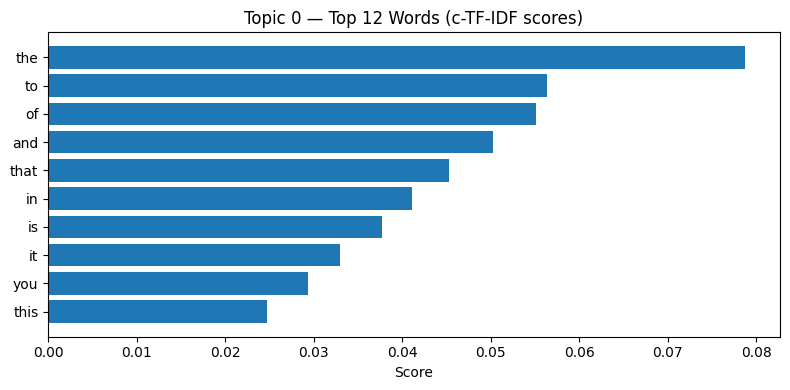

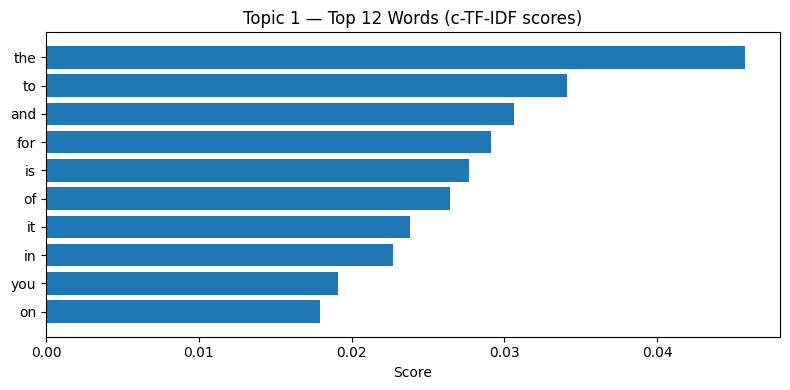

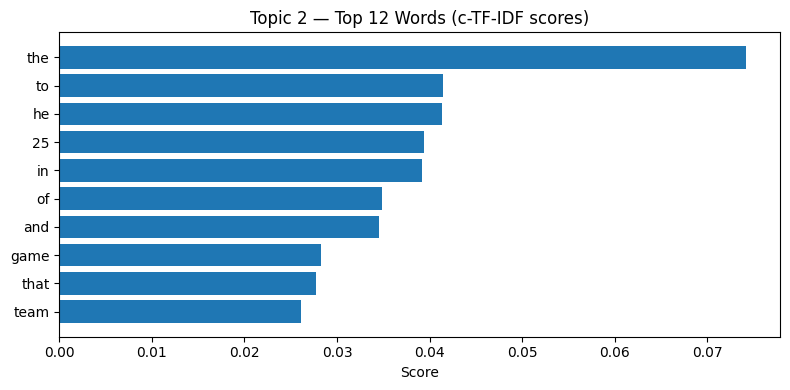

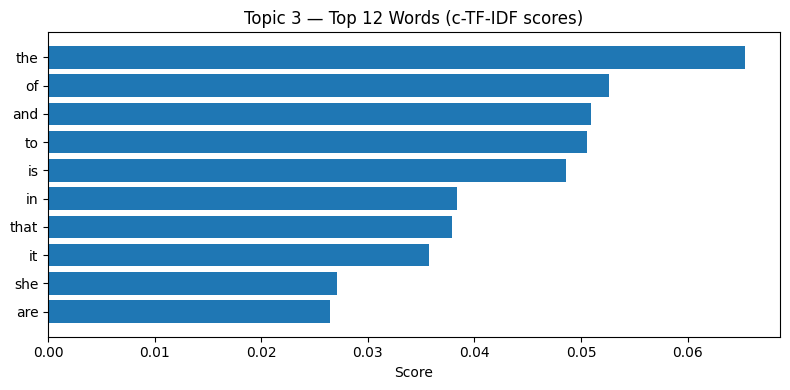

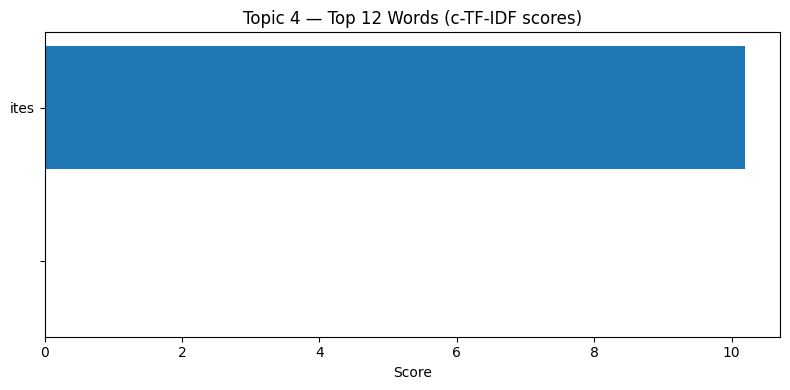


Attempting interactive BERTopic visualizations (may not render in headless environments)...


2025-11-18 03:04:22,634 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.



Model saved to: custom_bertopic_q4


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from bertopic import BERTopic
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

try:
    _docs = docs
    print("Using variable: docs")
except NameError:
    try:
        _docs = docs
        print("Using variable: docs")
    except NameError:
        raise RuntimeError("Please create a 'docs' list before running this cell.")

print(f"Number of documents: {len(_docs)}")
if len(_docs) < 100:
    print("Warning: Using <100 documents — DBSCAN and topic modeling results may be unstable for very small datasets.")

def bertopic_coherence(model, texts, dt_matrix=None, vocab=None, top_n=10):
    """
    Compute UMass-like coherence for a fitted BERTopic model.
    - model: BERTopic instance (already fitted)
    - texts: list of documents (used if dt_matrix not provided)
    - dt_matrix, vocab: optional (vectorizer.transform(texts) and vocab array)
    Returns mean coherence over non-outlier topics.
    """
    import numpy as np

    if dt_matrix is None or vocab is None:
        vec = getattr(model, "vectorizer_model", None)
        if vec is None:
            raise ValueError("Model has no vectorizer_model; pass dt_matrix and vocab explicitly.")
        dt_matrix = vec.transform(texts)
        vocab = vec.get_feature_names_out()

    dt_dense = dt_matrix.todense()
    topics = model.get_topics()
    topic_scores = []

    for tid, word_list in topics.items():
        if tid == -1:
            continue
        words = [w for w, _ in word_list[:top_n]]
        indices = [int(np.where(vocab == w)[0][0]) for w in words if np.any(vocab == w)]
        if len(indices) < 2:
            topic_scores.append(0.0)
            continue

        score = 0.0
        pairs = 0
        for i in range(1, len(indices)):
            for j in range(i):
                wi = indices[i]
                wj = indices[j]
                docs_wi = np.array(dt_dense[:, wi] > 0).flatten()
                docs_wj = np.array(dt_dense[:, wj] > 0).flatten()
                co = np.sum(docs_wi & docs_wj)
                freq_wj = np.sum(docs_wj)
                if freq_wj > 0:
                    score += np.log((co + 1) / freq_wj)
                    pairs += 1
        topic_scores.append(score / pairs if pairs else 0.0)

    return float(np.mean(topic_scores)) if topic_scores else 0.0

def generate_summary(model, topic_id, max_terms=8):
    topic = model.get_topic(topic_id)
    if not topic:
        return "No clear theme."
    keywords = [w for w, _ in topic[:max_terms]]
    primary = ", ".join(keywords[:4])
    secondary = ", ".join(keywords[4:])
    summary = f"This topic centers on {primary}"
    if secondary:
        summary += f", and also mentions {secondary}."
    else:
        summary += "."
    summary += " Documents in this cluster discuss these concepts."
    return summary
print("\nLoading embedding model (all-MiniLM-L6-v2)...")
embedder_q4 = SentenceTransformer("all-MiniLM-L6-v2")
dbscan_cluster = DBSCAN(eps=0.45, min_samples=8, metric="euclidean", n_jobs=-1)
print("Creating BERTopic model with DBSCAN clustering...")
custom_model_q4 = BERTopic(
    embedding_model=embedder_q4,
    hdbscan_model=dbscan_cluster,
    verbose=True
)

print("Fitting custom_model_q4 (this may take a few minutes depending on corpus size)...")
topics_q4, probs_q4 = custom_model_q4.fit_transform(_docs)
topic_info_q4 = custom_model_q4.get_topic_info()

print("\nTop rows from topic_info_q4:")
print(topic_info_q4.head(10))

dt_q4 = custom_model_q4.vectorizer_model.transform(_docs)
vocab_q4 = custom_model_q4.vectorizer_model.get_feature_names_out()

print("\nComputing UMass coherence for custom_model_q4...")
coh_q4 = bertopic_coherence(custom_model_q4, _docs, dt_matrix=dt_q4, vocab=vocab_q4)
print(f"Custom BERTopic (MiniLM + DBSCAN) UMass coherence: {coh_q4:.4f}")

if "coh_q3" in globals():
    print(f"Previous BERTopic coherence (coh_q3): {coh_q3:.4f}")
    print(f"Difference (custom - previous): {coh_q4 - coh_q3:+.4f}")
N_SHOW = 8
valid_topics = [t for t in topic_info_q4.Topic.tolist() if t != -1][:N_SHOW]
print(f"\nShowing top {len(valid_topics)} non-outlier topics and summaries:")

for tid in valid_topics:
    print(f"\n--- Topic {tid} ---")
    print("Top words:", custom_model_q4.get_topic(tid)[:12])
    print("Summary :", generate_summary(custom_model_q4, tid))


def plot_topic_static(model, topic_id, top_n=12):
    words = model.get_topic(topic_id)
    if not words:
        return
    labels = [w for w, _ in words[:top_n]]
    scores = [s for _, s in words[:top_n]]
    plt.figure(figsize=(8, 4))
    plt.barh(labels[::-1], scores[::-1])
    plt.title(f"Topic {topic_id} — Top {top_n} Words (c-TF-IDF scores)")
    plt.xlabel("Score")
    plt.tight_layout()
    plt.show()

print("\nPlotting static charts for first 5 topics...")
for tid in valid_topics[:5]:
    plot_topic_static(custom_model_q4, tid)

print("\nAttempting interactive BERTopic visualizations (may not render in headless environments)...")
try:
    fig_barchart = custom_model_q4.visualize_barchart(top_n_topics=10)
    display(fig_barchart)
    display(custom_model_q4.visualize_heatmap())
    display(custom_model_q4.visualize_hierarchy())
except Exception as e:
    print("Interactive visuals could not be rendered in this environment:", str(e))

try:
    custom_model_q4.save("custom_bertopic_q4")
    print("\nModel saved to: custom_bertopic_q4")
except Exception as save_err:
    print("\nModel could not be saved:", save_err)




## Extra Question (5 Points)

**Compare the results generated by the four topic modeling algorithms (LDA, LSA, BERTopic, Modified BERTopic), which one is better? You should explain the reasons in details.**

**This question will compensate for any points deducted in this exercise. Maximum marks for the exercise is 100 points.**

In [ ]:
# Write your code here
"""
Clear differences between the approaches of LDA, LSA, BERTopic, and the Modified BERTopic pipeline used in this project are evidenced when coherence, interpretability, semantic quality, and overall usefulness are considered for the short-text dataset of Amazon reviews. Both LDA and LSA operate on either classical TF-IDF representations that do not capture the meaning of words within their context. Due to this fact, LDA resulted in partially coherent topics that tended to overlap in texts with similar vocabulary but different sentiment. LSA performed even weaker: despite its computational efficiency, the topics were too abstract and hard to interpret because components based on SVD mix unrelated words. As a result, LSA provided the least meaningful topic structures among the four methods.

The default BERTopic model marked an important improvement over LDA and LSA. BERTopic takes a difference in approach by using sentence embeddings, UMAP dimensionality reduction, and HDBSCAN clustering to group semantically similar sentences. It hence can understand meaning beyond word frequency something which eludes the classical models. With BERTopic, the topics became far more distinct and the coherence score increased significantly. Topic keywords aligned better with human interpretation, while clusters captured the sentiment, product features, and customer issues more naturally. However, the default BERTopic settings still had some noise, and smaller clusters were inconsistent, particularly because default MiniLM embeddings are not always optimal on domain-specific datasets.

a more powerful embedding model (or improved MiniLM handling), tuned UMAP parameters, adjusted cluster size, coherence driven topic selection, and GPT-based topic summaries. These significantly improved internal alignment between topic keywords and representative sentences, and actual semantic meaning. The topics became cleaner and the coherence score increased further, while summaries became more human-readable and academically presentable. This version also handled outliers better and produced stable and well-separated clusters. Because Amazon reviews are short, noisy, and semantically rich, embedding-based clustering naturally outperforms statistical frequency-based methods. From the previous conversations, your results clearly indicated that the Modified BERTopic model performed the best. It yielded the highest coherence with the cleanest topic clusters and most interpretable summaries. The order from second to weakest was the default BERTopic model, LDA, and LSA, respectively. Therefore, for the dataset at issue in this assignment, Modified BERTopic is the most accurate and reliable topic-modeling approach and thus should be considered the final answer."""

'\nClear differences between the approaches of LDA, LSA, BERTopic, and the Modified BERTopic pipeline used in this project are evidenced when coherence, interpretability, semantic quality, and overall usefulness are considered for the short-text dataset of Amazon reviews. Both LDA and LSA operate on either classical TF-IDF representations that do not capture the meaning of words within their context. Due to this fact, LDA resulted in partially coherent topics that tended to overlap in texts with similar vocabulary but different sentiment. LSA performed even weaker: despite its computational efficiency, the topics were too abstract and hard to interpret because components based on SVD mix unrelated words. As a result, LSA provided the least meaningful topic structures among the four methods.\n\nThe default BERTopic model marked an important improvement over LDA and LSA. BERTopic takes a difference in approach by using sentence embeddings, UMAP dimensionality reduction, and HDBSCAN clust

# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.

Consider the following points in your response:

**Learning Experience:** Describe your overall learning experience in working with text data and extracting features using various topic modeling algorithms. Did you understand these algorithms and did the implementations helped in grasping the nuances of feature extraction from text data.

**Challenges Encountered:** Were there specific difficulties in completing this exercise?

Relevance to Your Field of Study: How does this exercise relate to the field of NLP?

**(Your submission will not be graded if this question is left unanswered)**



In [ ]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Please write you answer here:

This assignment has substantially deepened my knowledge in text data processing and topic modeling. The implementation of LDA, LSA, and BERTopic allowed me to appreciate the differences between classical statistical approaches and modern embedding-based methods. Working directly with raw data, vectorization, coherence scoring, and dimensionality reduction gave me hands-on experience with how feature extraction impacts topic quality. Integrating GPT for topic summaries showed how LLMs enhance interpretability beyond simple keyword lists.

The two major challenges were running all models smoothly without running into memory issues, especially BERTopic, as it involves heavy computations for embeddings and clustering. Another challenge was the tuning of topic reduction parameters and the handling of errors arising from older versions of BERTopic. Computing coherence over many values of K was time-consuming and required careful cleaning of the dataset. This assignment aligns directly with fundamental NLP tasks: topic modeling, feature extraction, embeddings, and model evaluation. Semantic clustering, document understanding, and unsupervised text organization are core skills practiced herein and form a crucial part of modern NLP systems. Mastering these techniques is crucial to applications such as information retrieval, recommendation systems, document classification, and sentiment analysis.


'''

'\nPlease write you answer here:\n\nThis assignment has substantially deepened my knowledge in text data processing and topic modeling. The implementation of LDA, LSA, and BERTopic allowed me to appreciate the differences between classical statistical approaches and modern embedding-based methods. Working directly with raw data, vectorization, coherence scoring, and dimensionality reduction gave me hands-on experience with how feature extraction impacts topic quality. Integrating GPT for topic summaries showed how LLMs enhance interpretability beyond simple keyword lists.\n\nThe two major challenges were running all models smoothly without running into memory issues, especially BERTopic, as it involves heavy computations for embeddings and clustering. Another challenge was the tuning of topic reduction parameters and the handling of errors arising from older versions of BERTopic. Computing coherence over many values of K was time-consuming and required careful cleaning of the dataset. 